In [1]:
#import the library pulp as p
# import pulp as p
# from pulp import *
import pandas as pd
import numpy as np
import math
from scipy.stats import norm
from scipy.optimize import minimize
from pathlib import Path
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB, quicksum
from scipy.optimize import minimize

#import the necessary functions
from Interpolation_functions import *

# from Functions_for_BS import *
# from Common_functions import *

In [2]:
import gurobipy as gp
print(gp.gurobi.version())
model = gp.Model()
print("License ID:", model.getParamInfo("LicenseID"))

(12, 0, 2)
Set parameter Username
Set parameter LicenseID to value 2669587
Academic license - for non-commercial use only - expires 2026-05-22
License ID: ('LicenseID', <class 'int'>, 2669587, 0, 2000000000, 0)


In [3]:
#common parameters for all the experiments/GLOBAL VARIABLES

stock = 1 #initial stock price

K = 1 # target option's strike price

r = 0 #risk-free rate of interest

sigma = 0.2 #volatility of the stock price

T = 1 #target maturity

mu = 0 #return of the stock price

t = 0

timepoints =2 #number of timesteps


T_GRID = [0,0.5,T]#times at which the marginals of the stock price are evaluated

short_maturity = T_GRID[1] # maturity of the options in the hedge portfolio


#short_strike_range = [1,1.1,0.9,1.2,0.8,1.25,1.05,0.85,]#range of short strikes for increasing number of options

In [4]:
def Asian_option_payoff(stock_price_t1,stock_price_T,strike_price):
    return np.maximum(0.5*(stock_price_t1+stock_price_T)-strike_price,0)

**GET THE ASIAN OPTION'S VALUE FROM THE MOT PROBLEM**

In [5]:
#import the results from the Asian option MOT and compare the asian option values from the MOT and our hedging problem
# import pickle
# with open("result_Asian_MOT.pkl","rb") as f:
#     data_MOT = pickle.load(f)

    
# Target_option_value = data_MOT['Final_value']    
# print(f"Price of Asian option using MOT:{Target_option_value}")



In [6]:
#function to return the discretization points, call prices and the marginals for a given value of truncation range and number of discretization points and choice of uniform or nonuniform grid

def get_disc_points_and_marginals(truncation_range=None,n=None, N=None,choice="uniform"):
    """
       Generate the discretization points for the given problem depending on uniform or non-uniform grid
       Parameters: 
          Global variables: Stock, sigma, T,r,
          Local variables: n- (1/n) denotes the spacing between the discretization points
                        
    """
    if choice == "uniform":
        if truncation_range == None or n == None:
            return ("Need to provide n or truncation range")
        #return a uniform grid
        D = np.linspace(0, truncation_range, int(truncation_range*n)+1)
        
        
        #next we find the point where the interpolated line joining the last two strike points takes value zero
        R_0 = find_zero(BS_call,stock,D,T,sigma,r)
        
#         print(f"The interpolated line takes the value 0 at {R_0}")
        
        #print the corresponding call value
#         print(f"Strike:{R_0},Interpolated call value:{interpolated_line(stock,D,T,sigma,r,R_0)}")
        
        
        #extending the truncation range to include the new points till the zero of the interpolated call value
        K1_new = append_numbers(D,D[-1],R_0,np.diff(D)[0])
        
#         print(f"Extended truncation range for time {t1[1]}:{K1_new}")
#         print(f"length of new truncation range :{len(K1_new)}")
#         print(f"previous length:{len(D)}")
        
        K2_new = append_numbers(D,D[-1],R_0,np.diff(D)[0])
#         print(f"Extended truncation range for time {t1[2]}:{K2_new}")
#         print(f"spacing:{K2_new[-2]/(len(K2_new)-2)},{D[-1]/(len(D)-1)}") 
        
        
        #getting the new discretization points
        disc_points_new = disc_points_new_1(K1_new,K2_new)
        print(f"The new discretization points are:{disc_points_new}")
        
        # store the call prices as a 2D array
        call_prices_array_new = np.vstack((call_prices(stock,D,K1_new,T_GRID[1],sigma,r),
                                           call_prices(stock,D,K2_new,T,sigma,r)))
#         print(call_prices_array_new)
        
        #getting the discrete marginal distributions

        marg = marginal_new(call_prices_array_new,disc_points_new,timepoints,T_GRID)
#         print(marginal_new(call_prices_array_new,disc_points_new,timepoints,t1))
        
        
        #returns the grid and the number of grid points
        return disc_points_new,call_prices_array_new,marg
    else:
        if N == None:
            return print("Need to provide N")
        np.random.seed(12)
        grid = np.random.normal(K,sigma,N-2)# creating a grid concentrated around the target strike
        
        grid = np.append([0,truncation_range],grid)# adding 0 and the final truncation point to the list
        
        grid = np.sort(grid)# sorting the grid in ascending order
        
        
         #next we find the point where the interpolated line joining the last two strike points takes value zero
        R_0_T1 = find_zero(BS_call,stock,grid,T_GRID[1],sigma,r)
        print(f"The strike for time {T_GRID[1]} is {R_0_T1} and interpolated call value: {interpolated_line(stock,grid,T_GRID[1],sigma,r,R_0_T1)}")
        
        R_0_T = find_zero(BS_call,stock,grid,T,sigma,r)
        print(f"The strike for time {T} is {R_0_T} and interpolated call value: {interpolated_line(stock,grid,T,sigma,r,R_0_T)}")
        
        R_0 = max(R_0_T1,R_0_T)
        
#         #next we find the point where the interpolated line joining the last two strike points takes value zero
#         R_0 = find_zero(BS_call,stock, grid,T,sigma,r)
        
#         print(f"The interpolated line takes the value 0 at {R_0}")
        
#         #print the corresponding call value
#         print(f"Strike:{R_0},Interpolated call value:{interpolated_line(stock,grid,T,sigma,r,R_0)}")
        
        new_grid = np.append(grid,[R_0])
        
        K1_new = K2_new = new_grid
        
        #getting the new discretization points
        disc_points_new = disc_points_new_1(K1_new,K2_new)
        print(f"The new discretization points are:{disc_points_new}")
        print(f"Number of discretization points are:{len(K1_new)}")
        
                
        # store the call prices as a 2D array
        call_prices_array_new = np.vstack((call_prices(stock,grid,K1_new,T_GRID[1],sigma,r),call_prices(stock,grid,K2_new,T,sigma,r)))
#         print(call_prices_array_new)
        
        #getting the discrete marginal distributions

        marg = marginal_new(call_prices_array_new,disc_points_new,timepoints,T_GRID)
#         print(marginal_new(call_prices_array_new,disc_points_new,timepoints,T_GRID))
        
        #returns the grid and the number of grid points
        return disc_points_new,call_prices_array_new,marg
# print(BS_call(1000,990,0,1,0.05,0))

In [7]:
def get_target_call(marg, disc_points_new,K):
    """
    returns the price of the target option and the short-maturity options in the hedge portfolio
    Parameters:
       marg: marginal distributions, 
       disc_points_new: the discretization points 
    """
    N = len(disc_points_new[1]) #returns the number of discretization points corresponding to the target maturity
    target_call = sum(marg[1,i] * np.maximum(disc_points_new[1,i]- K,0) for i in range(N))
    return target_call
    


def get_short_call(t1,short_maturity,no_of_options,marg,disc_points_new,short_strikes):
    """
    returns the price of the target option and the short-maturity options in the hedge portfolio
    Parameters:
      t1: list of the time-points given by [0,short_maturity,target_maturity]
      short_maturity: maturity of the options in the hedge portfolio
      no_of_options: numner of options in the hedge portfolio
      marg: marginal distributions
      disc_points_new: discretization points
      short_strikes: strikes of the options in the hedge portfolio
    """
    short_call = np.zeros(no_of_options)
    
    L = t1.index(short_maturity)
    
    N = len(disc_points_new[0])#returns the number of discretization points corresponding to the short maturity
    
    #Value of short maturity options at time 0
    # short_call = \sum_{i}\alpha_i(x_i-short_strike)^+
    for j in range(no_of_options):
        short_call[j] = sum(marg[L-1,i] * np.maximum(disc_points_new[L-1,i]-short_strikes[j],0) \
                            for i in range(N))
        print("Short call value", str(j),"is:",short_call[j])
    return short_call





**SOLVE THE MAXIMIZATION PROBLEM WITHOUT M_BOUND**

In [8]:
def solve_max_problem_gurobi_without_M(M_bound,
    K1, K2,
    Weights_min_prev, short_strikes,short_call, target_strike,
    marg, Epsilon
):
    """
    A version of the 'solve_max_problem_gurobi' function that uses row-specific M_i
    instead of one global M_bound.
    """
    # Create a Gurobi model
    model = gp.Model("Upper-Bound-Problem-RowSpecificM")
    model.setParam('OutputFlag', 0)

    N = len(K1)
    no_of_options = len(short_strikes)

    # Decision variables
    X = model.addVars(N, N, lb=0, ub=1, vtype=GRB.CONTINUOUS, name="X")
    P_slack = model.addVars(N, lb=0, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS, name="P_slack")
    B = model.addVars(N, vtype=GRB.BINARY, name="B")
#     Delta = model.addVars(N, lb=0, vtype=GRB.CONTINUOUS, name="Delta")

    # Objective: Maximize sum of P_slack
    model.setObjective(quicksum(P_slack[i] for i in range(N)), GRB.MAXIMIZE)

    
  

    
     
    for i in range(N):
         # The hedging_error expression
        hedging_error = (quicksum(X[i, j] * Asian_option_payoff(K1[i],K2[j],target_strike) for j in range(N)) \
                        - marg[0][i] * (
                            Weights_min_prev[0]
                            + quicksum(
                                Weights_min_prev[l+1] * max(K1[i] - short_strikes[l], 0)
                                for l in range(no_of_options)
                            )
                           )
                        )
        # -- Absolute value constraints:
        # a) hedging_error <= P_slack[i]
        model.addConstr(hedging_error <= P_slack[i], f"modulus_1_{i}")

        # b) hedging_error >= -P_slack[i]
        model.addConstr(hedging_error >= -P_slack[i], f"modulus_2_{i}")

#         # d) hedging_error *(1 - 2*B[i]) == P_slack[i]
        model.addConstr(hedging_error *(1 - 2*B[i]) == P_slack[i], f"modulus_3_{i}")
        
    
#     # Sign[i] == 1  ->  e_i >= 0  &  P ==  e_i
#         model.addGenConstrIndicator(B[i], True,  hedging_error, GRB.GREATER_EQUAL, 0.0)
#         model.addGenConstrIndicator(B[i], True,  hedging_error - P_slack[i], GRB.EQUAL, 0.0)

#         # Sign[i] == 0  ->  e_i <= 0  &  P == -e_i
#         model.addGenConstrIndicator(B[i], False, hedging_error, GRB.LESS_EQUAL,   0.0)
#         model.addGenConstrIndicator(B[i], False, P_slack[i] + hedging_error , GRB.EQUAL, 0.0)
   
    # Marginal constraints
    for i in range(N):
        model.addConstr(quicksum(X[i, j] for j in range(N)) == marg[0][i], f"time1_{i}")

    for j in range(N):
        model.addConstr(quicksum(X[i, j] for i in range(N)) == marg[1][j], f"time2_{j}")

    # Martingale constraints 
   
    for i in range(N):
        model.addConstr(quicksum(X[i, j]*(K2[j] - K1[i]) for j in range(N)) == 0, f"martingale_{i}")
    
#     model.setParam('NonConvex', 2)

    # Solve the model
    model.optimize()

    if model.status != GRB.OPTIMAL:
        return {
            "call_value": float("inf"),
            "Status": model.status,
            "p_matrix": None,
            "P_slack": None,
            "B": None,
#             "Delta": None
        }
    
 
    # 6) Extract solution
    p_matrix = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            p_matrix[i, j] = X[i, j].X

    p_slack_array = np.array([P_slack[i].X for i in range(N)])
    b_array       = np.array([B[i].X          for i in range(N)])
#     delta_array   = np.array([Delta[i].X      for i in range(N)])
    call_value    = model.objVal

    return {
        "call_value": call_value,
        "Status": "Optimal",
        "p_matrix": p_matrix,
        "P_slack": p_slack_array,
        "B": b_array,
#         "Delta": delta_array,
       
    }


In [9]:
import cvxpy as cp

In [10]:
def min_max_optimization(
    solve_max_problem,
    M_bound,
    K1,
    K2,
    short_strikes,
    no_of_options,
    K,
    marg,
    short_call,
    Epsilon,
    x0, #initial choice for weights
    seed,
    bounds,
    regularization,
    lmda_reg
):
    """
    Returns the result of the min-max process for a given number of options
    in the hedge portfolio.
    """

    # Keep a log of intermediate values
    log = []

    n_timepoint_1 = len(marg[0])
    n_timepoint_2 = len(marg[1])

    def min_function_on_weights(Weights_with_cash):
        """
        Inner objective: given a set of hedge weights, solve the max problem
        and compute the "error" (sum of absolute differences).
        """

        # Solve the inner max problem
        result = solve_max_problem(
            M_bound,
            K1,
            K2,
            Weights_with_cash,
            short_strikes,
            short_call,
            K,
            marg,
            Epsilon
        )
        Status = result["Status"]
        if Status != "Optimal":
            # If infeasible or not optimal, penalize heavily
            print(f"Warning: Status is {Status}, no solution found.")
            return float("inf")

        # Retrieve the numeric arrays from the solver result dictionary
        p_matrix = result["p_matrix"]      # shape: (n_timepoint_1, n_timepoint_2)
        P_slack  = result["P_slack"]       # shape: (n_timepoint_1,)
        B_array  = result["B"]             # shape: (n_timepoint_1,)
#         Delta    = result["Delta"]         # shape: (n_timepoint_1,)
        call_val = result["call_value"]    # the objective in the solve_max_problem

        # Compute the "error" function f_w_pr:
        #    sum over i of | sum_{j} p_matrix[i,j]*(K2[j] - K)^+
        #                     - alpha_i*(hedge payoff at i) |
        alpha = marg[0]
        f_w_pr = 0.0
        
        
        #compute the optimal cash position 
        cash =  Weights_with_cash[0] 
        Weights_of_options = Weights_with_cash[1:] 
        
        #compute the objective value and hedge value
        hedge_value = 0
        for i in range(n_timepoint_1):
            payoff_target = sum(
                p_matrix[i,j] * Asian_option_payoff(K1[i],K2[j],K) 
                for j in range(n_timepoint_2))
            

            payoff_hedge = alpha[i] * (cash
                + sum(
                    Weights_of_options[l] * max(K1[i] - short_strikes[l], 0)
                    for l in range(no_of_options)
                )
            )
            f_w_pr += abs(payoff_target - payoff_hedge)
            hedge_value += payoff_hedge
        
        
        #compute the target option price
        target_price = 0
        for i in range(n_timepoint_1):
            for j in range(n_timepoint_2):
                target_price +=  p_matrix[i,j] * Asian_option_payoff(K1[i],K2[j],K)
        
       
        
        #if regularization is done through lasso or ridge
        if regularization:
            if lmda_reg == None:
                raise ValueError("lmda_reg must be provided")
            reg_type = regularization.lower()
            if reg_type == "lasso":
                #add a regularization term
                regularisation_term = lmda_reg * sum(abs(w) for w in Weights_with_cash)
                f_w_pr += regularisation_term
            
            elif regularization == "ridge":
            
                  #add a regularization term
                regularisation_term = lmda_reg * sum(w**2 for w in Weights_with_cash)
                f_w_pr += regularisation_term
            else:
                raise ValueError("Regularization must be lasso, ridge or none")
        
        
        # Record everything in our log
        log_entry = {
            "Weights": Weights_with_cash,
            "cash": cash,
            "Objective value (outer)": f_w_pr,
            "p_matrix": p_matrix,
            "P_slack": P_slack,
            "B": B_array,
#             "Delta": Delta,
            "call_value (inner)": call_val,
            "Status": Status,
            "target_price": target_price,
            "hedge_value": hedge_value
        }
        log.append(log_entry)
        print(f"value from gurobi:{call_val}")
        print(f"val solving max LP:{f_w_pr}\n")
       
        return f_w_pr

   
      # pick solver function
    
    result_dual_annealing = minimize(fun=min_function_on_weights,bounds= bounds,
                                     method='Nelder-Mead',
                                     x0 = x0,
                                      options=dict(maxiter=10000*(no_of_options+1),
                                                   maxfev=10000*(no_of_options+1),fatol= 1e-8, xatol= 1e-6,
                                                   disp=True)
                                                   
                                    )

    if result_dual_annealing.success:
        w_opt = result_dual_annealing.x
        final_value = result_dual_annealing.fun
        print(result_dual_annealing.message)
        return w_opt, final_value, log
    else:
        print("Simulated annealing failed")
        return None, float("inf"), log


In [11]:
def check_constraints_pulp_solution_no_M(
    M_bound,
    K1, K2,
    Weights,         # [cash, w1, w2, ...]
    short_strikes,
    target_strike,
    marg,
    epsilon,
    solution_dict,
    tolerance=1e-8
):
    """
    Re-checks constraints from solve_max_problem_gurobi_without_M.
    Returns (all_satisfied, violations).
    """

    # ============= 1) Basic Setup =============
    n_timepoint_1 = len(marg[0])  # alpha
    n_timepoint_2 = len(marg[1])  # beta
    no_of_options = len(short_strikes)

    # Extract final solution arrays
    p_matrix = solution_dict["p_matrix"]  # shape (n_timepoint_1, n_timepoint_2)
    P_slack  = solution_dict["P_slack"]   # shape (n_timepoint_1,)
    B_array  = solution_dict["B"]         # shape (n_timepoint_1,)

    # If solver not optimal or p_matrix is None -> skip
    if solution_dict["Status"] != "Optimal" or p_matrix is None:
        return (
            False,
            [f"Solver status {solution_dict['Status']} or p_matrix=None => skip check"]
        )

    violations = []

    # ============= 2) Timepoint 1 Constraints =============
    # sum_j p[i,j] == marg[0][i]
    for i in range(n_timepoint_1):
        lhs = np.sum(p_matrix[i,:])
        rhs = marg[0][i]
        if abs(lhs - rhs) > tolerance:
            msg = f"Row sum constraint violated at i={i}: LHS={lhs}, RHS={rhs}"
            violations.append(msg)

    # ============= 3) Timepoint 2 Constraints =============
    # sum_i p[i,j] == marg[1][j]
    for j in range(n_timepoint_2):
        lhs = np.sum(p_matrix[:, j])
        rhs = marg[1][j]
        if abs(lhs - rhs) > tolerance:
            msg = f"Column sum constraint violated at j={j}: LHS={lhs}, RHS={rhs}"
            violations.append(msg)

    # ============= 4) Martingale Constraints =============
    # sum_j p[i,j]*(K2[j] - K1[i]) = 0  for each i
    for i in range(n_timepoint_1):
        lhs = 0.0
        for j in range(n_timepoint_2):
            lhs += p_matrix[i, j]*(K2[j] - K1[i])
        if abs(lhs) > tolerance:
            msg = f"Martingale constraint violated at i={i}: LHS={lhs}"
            violations.append(msg)

    # ============= 5) Absolute Value (No Big M) Constraints =============
    # For each i, define:
    # hedging_error = sum_j p[i,j]*(K2[j]-target_strike)^+
    #               - alpha[i]*(cash + sum_l W[l+1]*(K1[i]-short_strikes[l])^+)
    # 1) hedging_error <= P_slack[i]
    # 2) hedging_error >= -P_slack[i]
    # 3) hedging_error*(1 - 2*B[i]) == P_slack[i]

    alpha = marg[0]
    cash  = Weights[0]
    w_opts = Weights[1:]  # the short positions
  

    for i in range(n_timepoint_1):
        # payoff_target
        payoff_target = 0.0
        for j in range(n_timepoint_2):
            payoff_target += p_matrix[i,j] * Asian_option_payoff(K1[i], K2[j], target_strike) 

        # payoff_hedge
        payoff_hedge = alpha[i]*(
            cash + sum(
                w_opts[l] * max(K1[i] - short_strikes[l], 0)
                for l in range(no_of_options)
            )
        )

        hedging_error = payoff_target - payoff_hedge

        # 1) hedging_error <= P_slack[i]
        if hedging_error - P_slack[i] > tolerance:
            msg = (f"Absolute-value constraint #1 violated i={i}: "
                   f"hedging_error={hedging_error}, P_slack={P_slack[i]}")
            violations.append(msg)

        # 2) hedging_error >= -P_slack[i]
        if hedging_error + P_slack[i] < -tolerance:
            msg = (f"Absolute-value constraint #2 violated i={i}: "
                   f"hedging_error={hedging_error}, P_slack={P_slack[i]}")
            violations.append(msg)

        # 3) hedging_error*(1-2*B[i]) == P_slack[i]
        lhs_3 = hedging_error*(1 - 2*B_array[i])
        if abs(lhs_3 - P_slack[i]) > tolerance:
            msg = (f"Absolute-value constraint #3 violated i={i}: "
                   f"lhs_3={lhs_3}, P_slack={P_slack[i]}, B={B_array[i]}")
            violations.append(msg)

    # ============= Finalize =============
    all_satisfied = (len(violations) == 0)
    return (all_satisfied, violations)


In [12]:
###############################################################################
#  MAIN DRIVER (run_experiment) 
###############################################################################
    # Build grid & marginals
def run_experiment_no_M(solver=None,
    truncation_range=None,
    n=None,
    N=None,
    no_of_options=None,
    short_strikes=None,
    epsilon=None,
    M_bound=None,
    choice=None,
    x0=None,
    seed=136, 
    bounds=None, 
    regularization=None,
    lmda_reg=None                   
):
    """
    Orchestrates everything:
     1) Build discretization points & marginals
     2) Pick short strikes
     3) Compute target call & short calls
     4) Solve min-max
     5) Return final results
    """
    disc_points_new, call_prices_array_new, marg = get_disc_points_and_marginals( truncation_range=truncation_range,\
                                                                                n=n,N=N,choice=choice)
    

    K1 = disc_points_new[0]
    
    K2 = disc_points_new[1]
   
    # Pick short strikes
    
    print(f"Short strikes: {short_strikes}")

    # Compute  short calls

    short_call = get_short_call(T_GRID, T_GRID[1], no_of_options, marg, disc_points_new, short_strikes)
    print(f"length of short_call {len(short_call)}")

    

     
    # pick solver function
    # if solver.lower() == "pulp":
    #     solver_func = solve_max_problem_pulp
    # else:
    solver_func = solve_max_problem_gurobi_without_M

  
    # solve the min_max
    w_opt, final_value, log_results = min_max_optimization(
        solver_func,
        M_bound,
        K1, 
        K2,
        short_strikes,
        no_of_options,
        K,
        marg,
        short_call,
        epsilon,
        x0,
        seed,
        bounds,
        regularization,
        lmda_reg
    )
    
    if w_opt is None:
        # pick the log entry with the smallest objective value
        best = min(log_results, key=lambda d: d["Objective value (outer)"])
        w_opt       = best["Weights"]
        final_value = best["Objective value (outer)"]
        print("Using best point from log; optimiser did not converge.")
    

    # Solve the max problem once more with final_weights
    final_solution = solver_func(
        M_bound,
        K1,
        K2,
        w_opt,
        short_strikes,
        short_call,
        K,
        marg,
        epsilon
    )
    
 

    # Re-compute the target_call
   
    prob_matrix_final = final_solution["p_matrix"]
    target_call = 0
    n_timepoint_1 = len(K1)
    n_timepoint_2 = len(K2)
    
    for i in range(n_timepoint_1):
        for j in range(n_timepoint_2):
            target_call += prob_matrix_final[i][j]* Asian_option_payoff(K1[i],K2[j],K)
    
    hedge_value = w_opt[0] + np.dot(w_opt[1:],short_call)

    # 8) Check constraints using the existing check_constraints_pulp_solution function
   
    if final_solution["Status"] =="Optimal" and final_solution["p_matrix"] is not None:
        all_satisfied, violations = check_constraints_pulp_solution_no_M(
            M_bound,
            K1, K2,
            w_opt,
            short_strikes,
            K,
            marg,
            epsilon,
            final_solution,
            tolerance=1e-8 
        )

        if all_satisfied:
            print("All constraints are satisfied at the final solution!")
        else:
            print("Constraint violations found at the final solution:")
            for v in violations:
                print("  -", v)
    else:
        print("Final solution wasn't optimal, so skipping constraint check.")

   
    # 9) Return final results
    return {
        "w_opt": w_opt,
        "final_value": final_value,
        "log": log_results,
        "N_initial": N, #initial choice of discretization points
        "N": len(K1),#total number of discretization points after interpolation 
        "Value_inner":final_solution["call_value"],
        "p_matrix": final_solution["p_matrix"],
        "target_call_price": target_call,
        "hedge_value": hedge_value
    }

**FIX THE TRUNCATION RANGE, NUMBER OF DISCRETIZATION POINTS AND SHORT STRIKE RANGE**

In [13]:
N = 14 #number of discretization points

truncation_range = 2 #truncation range for the discretization points

disc_points_new, call_prices_array_new, marg = get_disc_points_and_marginals( truncation_range=truncation_range,
                                                                            N=N,
                                                                            choice="non-uniform")


#the discretization points
K1, K2 = disc_points_new 

#the list of all short_strikes

short_strike_range = [round(float(disc_points_new[0][7]),4),
                 round(float(disc_points_new[0][6]),4),
                 round(float(disc_points_new[0][8]),4),
                 round(float(disc_points_new[0][5]),4),
                 round(float(disc_points_new[0][9]),4),
                 round(float(disc_points_new[0][4]),4),
                 round(float(disc_points_new[0][11]),4)]

print(f"\n The available short strikes are: { short_strike_range}")

The strike for time 0.5 is 2.0002422164631994 and interpolated call value: -5.532183936754649e-21
The strike for time 1 is 2.0081747254138964 and interpolated call value: -1.0842021724855044e-19
The new discretization points are:[[0.         0.65985287 0.69305573 0.83860362 0.86371482 0.88043542
  0.97595447 1.00102542 1.0484879  1.0944914  1.09459717 1.15062857
  1.57436388 2.         2.00817473]
 [0.         0.65985287 0.69305573 0.83860362 0.86371482 0.88043542
  0.97595447 1.00102542 1.0484879  1.0944914  1.09459717 1.15062857
  1.57436388 2.         2.00817473]]
Number of discretization points are:15
timepoint: 0.5
15
Sum of marginals at 0.5 is: 1.0
timepoint: 1
15
Sum of marginals at 1 is: 1.0

 The available short strikes are: [1.001, 0.976, 1.0485, 0.8804, 1.0945, 0.8637, 1.1506]


In [14]:
# #DEFINE A FUNCTION TO PLOT THE CONDITIONAL TARGET OPTION AND HEDGE PORTFOLIO VALUES

# def plot_one_run(K1,K2,N, truncation_range, weights, P_matrix, no_of_options_t1,
#                  run_idx=None,
#                  save=False, save_dir="plots", show=True):
#     """Draw (and optionally save) the target/BS/hedge curves for one run."""
    
   
#     price     = np.zeros(len(K1))
#     BS_price  = np.zeros(len(K1))
#     hedge     = np.zeros(len(K1))
#     Pr_opt    = P_matrix
#     alpha     = marg[0]          
#     tolerance = 1e-17
    
#     # loop over K1 grid
#     for i, k1 in enumerate(K1):
#         #   target conditional price
#         if alpha[i] < tolerance:
#             price[i] = np.nan
#         else:
#             price[i] = sum(
#                 Pr_opt[i, j] * Asian_option_payoff(k1, K2[j], K)
#                 for j in range(len(K2))
#             ) / alpha[i]

#         #   BS proxy
#         BS_price[i] = (
#             0.5 * BS_call(k1, -k1 + 2 * K, T_GRID[1], T, sigma, r)
#             if 2 * K - k1 >= 0
#             else k1 - K
#         )

#         #   hedge value
#         cash = weights[0]
#         wopt = weights[1:]
#         hedge[i] = cash + sum(
#             wopt[l] * max(k1 - short_strike_range[l], 0)
#             for l in range(no_of_options_t1)
#         )

#     # plotting
#     plt.figure(figsize=(5, 3))
#     l=-2
#     plt.plot(K1[2:l], price[2:l], label="target")
#     plt.plot(K1[2:l], BS_price[2:l], label="BS target price")
#     plt.plot(K1[2:l], hedge[2:l], label="hedge portfolio")
#     plt.xlabel("Stock price at short maturity")
#     plt.ylabel("value")
#     plt.title(f"N={N}, trunc={truncation_range}")
#     plt.legend()
#     plt.tight_layout()

#     # ---- 5) save / show
#     if save:
#         import os
#         os.makedirs(save_dir, exist_ok=True)
#         fname = f"plot_N{N}_{run_idx}.png" if run_idx is not None else f"plot_N{N_init}.png"
#         plt.savefig(os.path.join(save_dir, fname), dpi=300, bbox_inches="tight")
#     if show:
#         plt.show()
#     else:
#         plt.close()

In [15]:


def plot_one_run(
        K1, K2,
        truncation_range, N,
        weights, P_matrix,           # hedge weights and optimal joint-prob.
        marg,                        # alpha-vector passed explicitly
        K, T_GRID, sigma, r,         # model constants
        short_strikes,               # array of strikes actually used
        run_idx=None,                # optional run counter (for the file name)
        *,
        save=False,
        folder="plots",              # default folder
        fname=None,                  # default file name pattern
        show=True,
        asian_payoff=None,           # inject the payoff & BS call you use
        bs_call=None,
        lo = None,
        hi = None                    # cut off ends if desired
):
    """
    Draw target, conditional target price and hedge‐portfolio curves.

    Parameters
    ----------
    …
    save        : bool  – write the figure to disk?
    folder      : str|Path – destination directory (created if absent)
    fname       : str|None – file name; if None a default is built
    show        : bool  – show on screen (True) or just save/close (False)
    """

    # ------------------------------------------------------------------ #
    # 1.  Pre-allocate
    # ------------------------------------------------------------------ #
    price    = np.zeros_like(K1, dtype=float)
    bs_price = np.zeros_like(K1, dtype=float)
    hedge    = np.zeros_like(K1, dtype=float)

    cash, wopt = weights[0], np.asarray(weights[1:])
    alpha      = np.asarray(marg[0])
    tol        = 1e-17
    m          = len(short_strikes)

    # ------------------------------------------------------------------ #
    # 2.  Vectorised target & hedge computation
    # ------------------------------------------------------------------ #
    for i, k1 in enumerate(K1):
        if alpha[i] < tol:
            price[i] = np.nan
        else:
            price[i] = (P_matrix[i] *
                        asian_payoff(k1, K2, K)).sum() / alpha[i]

        bs_price[i] = (
            0.5 * bs_call(k1, -k1 + 2*K, T_GRID[1], T_GRID[-1], sigma, r)
            if 2*K - k1 >= 0 else k1 - K
        )

        hedge[i] = cash + np.sum(
            wopt * np.maximum(k1 - short_strikes[:m], 0.0))

    # ------------------------------------------------------------------ #
    # 3.  Plot
    # ------------------------------------------------------------------ #
    # plt.figure(figsize=(5, 3))
    
    # plt.plot(K1[lo:hi], price[lo:hi],    label="Target")
    # plt.plot(K1[lo:hi], bs_price[lo:hi], label="BS price")
    # plt.plot(K1[lo:hi], hedge[lo:hi],    label="Hedge")
    # plt.xlabel("stock price at $t_1$")
    # plt.ylabel("value")
    # plt.title(f"N={N}, No_of_options={no_of_options}")
    # plt.legend()
    # plt.tight_layout()
#causing an error
    
    # ------------------------------------------------------------------ #
    # 4.  Save / show
    # ------------------------------------------------------------------ #
    
    if save:
        from datetime import datetime
        folder = Path(folder)
        folder.mkdir(parents=True, exist_ok=True)

        # timestamp: YYYY-MM-DD_HHMMSS
        ts  = datetime.now().strftime("%Y-%m-%d_%H%M%S")

        # build a default file name if none supplied
        if fname is None:
            tag  = f"N{N}_run{run_idx}" if run_idx is not None else f"N{N}"
            base = f"hedge_plot_{tag}.png"
        else:
            base = fname if fname.endswith(".png") else f"{fname}.png"

        full_name = f"{ts}_{base}"          # prepend timestamp
        full_path = folder / full_name

        plt.savefig(full_path, dpi=300, bbox_inches="tight")

        # ------------- append a tiny CSV log -----------------------------
        logfile = folder / "plot_index.csv"
        with logfile.open("a") as f:
            # csv columns: timestamp , file_name , run_idx , trunc , N
            f.write(f"{ts},{full_name},{run_idx},{truncation_range},{N}\n")
    if show:
        plt.show()
    else:
        plt.close()


**SIMULATE STOCK PATHS TO LATER USE FOR PFE CALCULATIONS **

Index corresponding to short maturity 0.5 :10
Index corresponding to target maturity 1.0 :20


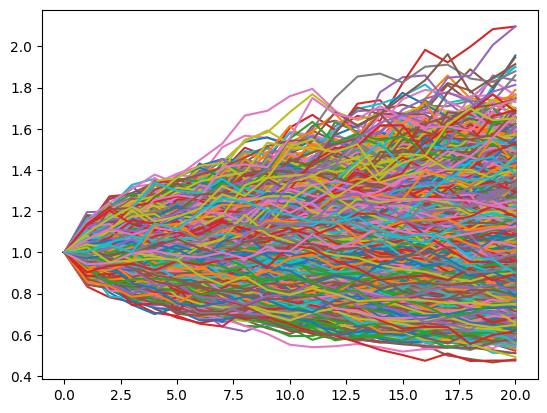

Time indices:
 [0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.30000000000000004, 0.35000000000000003, 0.4, 0.45, 0.5, 0.55, 0.6000000000000001, 0.65, 0.7000000000000001, 0.75, 0.8, 0.8500000000000001, 0.9, 0.9500000000000001, 1.0]


In [16]:
#### SIMULATE STOCK PATHS TO COMPUTE THE QUANTILES ####
if __name__ == "__main__" : 
    Nsim = 10000
    Nsteps = timepoints * 10
    delta_t = 1/Nsteps

    stock_paths = np.zeros([Nsim,Nsteps+1])
    stock_paths[:,0] = stock
    np.random.seed(2)
    Z1 = np.random.normal(size=[Nsim,Nsteps])

    time_indices = [] # list to store the corresponding time-points at which the stock paths are beong calculated
    time_indices.append(0)

    for i in range(Nsteps):
        stock_paths[:,i+1] = stock_paths[:,i] * np.exp((r - 0.5 * (sigma **2)) * delta_t \
            + sigma * np.sqrt(delta_t) * Z1[:,i])
    
        time_indices.append(delta_t * (i + 1))

    
    index1 = time_indices.index(T_GRID[1]) #index corresponding to short maturity
    index2 = time_indices.index(T) #index corresponding to target maturity

    print(f"Index corresponding to short maturity {time_indices[index1]} :{index1}")
    
    print(f"Index corresponding to target maturity {time_indices[index2]} :{index2}")
    
    #plot the stock paths
    t_paths = np.linspace(0, Nsteps, Nsteps+1)
    plt.plot(t_paths,stock_paths.transpose())
    plt.show()
    plt.close()
    
    #print the intermediate time points
    print(f"Time indices:\n {time_indices}")
    


In [17]:
def hedge_payoff_intermediate_time(stock_value,time_point,weights,short_strikes):
    """
     Computes the payoff of the hedge portfolio at intermediate time-points(<= short_maturity) 
    """
    if time_point < T_GRID[1]: # if time_point < short-maturity
        payoff_arrays =  [weights[l+1] * BS_call(stock_value, short_strikes[l], time_point,
                                                                    T_GRID[1], sigma, r) #creates a list of dimension 1000 x len(short_strikes)
                          for l in range(len(short_strikes))]
        payoff_hedge =  weights[0] + np.sum(payoff_arrays, axis = 0)
            
        
        
    if time_point == T_GRID[1]: # if time_point =  short maturity
        payoff_arrays = [weights[l+1] * np.maximum(stock_value - short_strikes[l],0)
                                            for l in range(len(short_strikes))]   
        payoff_hedge =  weights[0] + np.sum(payoff_arrays, axis = 0)
        
    return payoff_hedge
            

In [18]:
def target_payoff_intermediate_time(stock_value,time_point,T_GRID,target_strike):
    """
     Computes the payoff of the target option at intermediate time-points(less than or equal to the target maturity) 
     """
    target_value = 0
    if time_point < T_GRID[1]:# if time_point < short_maturity
        #first simulate the stock_paths at the short_maturity and T given the current stock price
        np.random.seed(5)
        N_sim_2 = 1000
        N_steps_2 = 2
        
        Z_normal = np.random.normal(size=[N_sim_2,N_steps_2])
        
        #time left to short maturity
        delta_t1 = T_GRID[1] - time_point
        
        stock_paths_initial = stock_value * np.ones(N_sim_2)
        
        #compute the stock prices at short maturity
        stock_paths_T1 = stock_paths_initial * np.exp((r - 0.5 * (sigma **2)) * delta_t1 \
            + sigma * np.sqrt(delta_t1) * Z_normal[:,0])
        
        #time difference between short maturity and target maturity
        delta_t2 = T_GRID[2] - T_GRID[1]
        
        #compute the stock prices at target maturity
        stock_paths_T =  stock_paths_T1 *   np.exp((r - 0.5 * (sigma **2)) * delta_t2 \
            + sigma * np.sqrt(delta_t2) * Z_normal[:,1])
        
        #compute the means
#         print(f"Average of the stock price values:{np.mean(stock_paths_T1),np.mean(stock_paths_T)}")
        
        #compute the payoff at maturity for the stock price paths
        target_value = np.mean([Asian_option_payoff(stock_paths_T1[i], stock_paths_T[i],target_strike) 
                               for i in range(N_sim_2)]) 

    elif time_point == T_GRID[1]: # if time_point = short_maturity
        
        if 2 * target_strike - stock_value >= 0:
            target_value = 0.5 * BS_call(stock_value,-stock_value + 2 * target_strike,T_GRID[1],T,sigma,r)
        else:
            target_value = stock_value - target_strike
    return target_value

In [19]:
def objective_value_for_stock_paths(time_point,stock_price_values, optimal_weights,T_GRID,K,short_strikes):
    """
    Compute the objective value for the stock price paths at a given time-point
    """
    
    
    
#     print(f"The short strikes are:{short_strikes}")
    
    objective_value = (target_payoff_intermediate_time(stock_price_values ,time_point,T_GRID,K) - 
           hedge_payoff_intermediate_time(stock_price_values, time_point, optimal_weights, short_strikes)
                      )

    return objective_value


**EXPERIMENT 1: Run the minimization algorithm without bounds on weights**

In [20]:
if __name__ == "__main__":

    
    list_of_objectives = []
    list_of_dictionaries = []
    
    no_of_options = 4
    short_strikes = short_strike_range[:no_of_options] 
    
   
    result_data_no_bounds = run_experiment_no_M(solver="gurobi",
        truncation_range=truncation_range,
        N=N,
        no_of_options=no_of_options,
        short_strikes=short_strikes,
        epsilon= 0,
        M_bound= 0,
        choice="non-uniform",
        x0 = [0,1,0,0,0] #[0] *(no_of_options+1 )
    )



    # Make a similar dictionary
    run_dict_no_bounds = {
        "Solver": "gurobi",
        "M_coeff": "No_M",   # or 0, or None—some label
        "Truncation_range": truncation_range,
        "N_initial": result_data_no_bounds["N_initial"],
        "N": result_data_no_bounds["N"],
        "no_of_options": no_of_options,
        "epsilon": 0.0,
        "Optimal_weights": result_data_no_bounds["w_opt"],
         "Final_value": result_data_no_bounds["final_value"],
         "P_matrix": result_data_no_bounds["p_matrix"],
        "Target_price": result_data_no_bounds["target_call_price"],
        "Hedge_value": result_data_no_bounds["hedge_value"]
     }
    print(f"========== Experiment Complete ==========")

    print("Optimal Weights:", result_data_no_bounds["w_opt"])
    print("Final Value from min-max:", result_data_no_bounds["final_value"])
        
        
#         current_objective = result_data_no_bounds["final_value"]
        
        
#         if i == 0:
#             previous_objective = current_objective
#             previous_dictionary = run_dict_no_M
#         else:    
#             if current_objective <= previous_objective:
#                 previous_objective = current_objective
#                 previous_dictionary = run_dict_no_M
            
#         list_of_objectives.append(current_objective)
#         list_of_dictionaries.append(run_dict_no_M)

The strike for time 0.5 is 2.0002422164631994 and interpolated call value: -5.532183936754649e-21
The strike for time 1 is 2.0081747254138964 and interpolated call value: -1.0842021724855044e-19
The new discretization points are:[[0.         0.65985287 0.69305573 0.83860362 0.86371482 0.88043542
  0.97595447 1.00102542 1.0484879  1.0944914  1.09459717 1.15062857
  1.57436388 2.         2.00817473]
 [0.         0.65985287 0.69305573 0.83860362 0.86371482 0.88043542
  0.97595447 1.00102542 1.0484879  1.0944914  1.09459717 1.15062857
  1.57436388 2.         2.00817473]]
Number of discretization points are:15
timepoint: 0.5
15
Sum of marginals at 0.5 is: 1.0
timepoint: 1
15
Sum of marginals at 1 is: 1.0
Short strikes: [1.001, 0.976, 1.0485, 0.8804]
Short call value 0 is: 0.055902473578919115
Short call value 1 is: 0.06851541075851549
Short call value 2 is: 0.03669138068430052
Short call value 3 is: 0.1328897732519189
length of short_call 4
value from gurobi:0.012065958626931996
val solving

In [21]:
#FIX THE FOLDER NAME
folder='BS_Asian_plots_MAY_2025'

In [22]:
#PLOT AND CHECK HOW IT LOOKS

Weights_opt_without_bounds = result_data_no_bounds["w_opt"]
P_matrix_no_bounds = result_data_no_bounds["p_matrix"]

plot_one_run( K1,
    K2,
    truncation_range,
    N,
    Weights_opt_without_bounds,
    P_matrix_no_bounds,
    marg,
    K,
    T_GRID,
    sigma,
    r,
    short_strikes,
    run_idx=None,
    save=True,
    folder=folder,
    fname='Conditional_plot_no_bounds_zoomed_in',
    show=True,
    asian_payoff=Asian_option_payoff,
    bs_call=BS_call,
    lo = 2,
    hi = -2
)
    


e:\Weight_predictor\Interpolation_functions.py:28: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(stock/K) + (r + 0.5 * ( sigma **2)) * tau)/ (sigma * np.sqrt(tau))


<Figure size 640x480 with 0 Axes>

In [23]:
run_dict_no_bounds['Hedge_value']

np.float64(0.05649213353692841)

In [24]:
truncation_range =2

N=19
choice ="non-uniform"
no_of_options =2 
disc_points_new, call_prices_array_new, marg = get_disc_points_and_marginals( truncation_range=truncation_range,\
                                                                               N=N,choice=choice)
    

K1 = disc_points_new[0]

K2 = disc_points_new[1]

# Pick short strikes
short_strikes = short_strike_range[:no_of_options] 
    
print(f"Short strikes: {short_strikes}")

# Compute  short calls

short_call = get_short_call(T_GRID, T_GRID[1], no_of_options, marg, disc_points_new, short_strikes)
print(f"length of short_call {len(short_call)}")

The strike for time 0.5 is 2.0002422164631994 and interpolated call value: -5.532183936754649e-21
The strike for time 1 is 2.0081747254138964 and interpolated call value: -1.0842021724855044e-19
The new discretization points are:[[0.         0.65985287 0.69305573 0.75696624 0.83860362 0.86371482
  0.88043542 0.97557004 0.97595447 1.00102542 1.0484879  1.0944914
  1.09459717 1.15062857 1.2025031  1.21919122 1.26847127 1.57436388
  2.         2.00817473]
 [0.         0.65985287 0.69305573 0.75696624 0.83860362 0.86371482
  0.88043542 0.97557004 0.97595447 1.00102542 1.0484879  1.0944914
  1.09459717 1.15062857 1.2025031  1.21919122 1.26847127 1.57436388
  2.         2.00817473]]
Number of discretization points are:20
timepoint: 0.5
20
Sum of marginals at 0.5 is: 1.0
timepoint: 1
20
Sum of marginals at 1 is: 1.0000000000000002
Short strikes: [1.001, 0.976]
Short call value 0 is: 0.05590247357891912
Short call value 1 is: 0.0685154107585155
length of short_call 2


In [25]:
M_bound = 0
Weights_min_prev = [1] *(no_of_options+1)
result = solve_max_problem_gurobi_without_M(M_bound,
    K1,
    K2,
    Weights_min_prev,
    short_strikes,
    short_call,
    K,
    marg,
    0,)

In [26]:
result['P_slack']

array([8.20130270e-05, 3.59184335e-03, 1.12986070e-02, 5.21647580e-02,
       7.58133721e-02, 4.20164933e-02, 1.41097679e-01, 1.32276768e-01,
       3.64146925e-02, 1.02282201e-01, 1.23663510e-01, 5.57433398e-02,
       5.61840224e-02, 8.96292262e-02, 4.26594746e-02, 2.91256249e-02,
       5.69479480e-02, 1.55925188e-02, 1.46101698e-04, 4.47919275e-06])

**EXPERIMENT 2: Run the minimization algorithm with bounds on weights**

In [27]:
if __name__ == "__main__":
    bounds = [(-1.2,1.2)]
    
    list_of_objectives = []
    list_of_dictionaries = []
    
    
    
   
    result_data_with_bounds = run_experiment_no_M(solver="gurobi",
        truncation_range=truncation_range,
        N=N,
        no_of_options=no_of_options,
        short_strikes=short_strikes,
        epsilon= 0,
        M_bound= 0,
        choice="non-uniform",
        x0 = [0] *(no_of_options+1 ),
        bounds = bounds * (no_of_options+1 )
    )



    # Make a similar dictionary
    run_dict_with_bounds = {
        "Solver": "gurobi",
        "M_coeff": "No_M",   # or 0, or None—some label
        "Truncation_range": truncation_range,
        "N_initial": result_data_with_bounds["N_initial"],
        "N": result_data_with_bounds["N"],
        "no_of_options": no_of_options,
        "epsilon": 0.0,
        "bounds": bounds,
        "Optimal_weights": result_data_with_bounds["w_opt"],
         "Final_value": result_data_with_bounds["final_value"],
         "P_matrix": result_data_with_bounds["p_matrix"],
        "Target_price": result_data_with_bounds["target_call_price"],
        "Hedge_value": result_data_with_bounds["hedge_value"]
     }
    print(f"========== Experiment Complete ==========")

    print("Optimal Weights:", result_data_with_bounds["w_opt"])
    print("Final Value from min-max:", result_data_with_bounds["final_value"])
        
        


The strike for time 0.5 is 2.0002422164631994 and interpolated call value: -5.532183936754649e-21
The strike for time 1 is 2.0081747254138964 and interpolated call value: -1.0842021724855044e-19
The new discretization points are:[[0.         0.65985287 0.69305573 0.75696624 0.83860362 0.86371482
  0.88043542 0.97557004 0.97595447 1.00102542 1.0484879  1.0944914
  1.09459717 1.15062857 1.2025031  1.21919122 1.26847127 1.57436388
  2.         2.00817473]
 [0.         0.65985287 0.69305573 0.75696624 0.83860362 0.86371482
  0.88043542 0.97557004 0.97595447 1.00102542 1.0484879  1.0944914
  1.09459717 1.15062857 1.2025031  1.21919122 1.26847127 1.57436388
  2.         2.00817473]]
Number of discretization points are:20
timepoint: 0.5
20
Sum of marginals at 0.5 is: 1.0
timepoint: 1
20
Sum of marginals at 1 is: 1.0000000000000002
Short strikes: [1.001, 0.976]
Short call value 0 is: 0.05590247357891912
Short call value 1 is: 0.0685154107585155
length of short_call 2
value from gurobi:0.067929

In [28]:
#PLOT AND CHECK HOW IT LOOKS

Weights_opt_with_bounds = result_data_with_bounds["w_opt"]
P_matrix_with_bounds = result_data_with_bounds["p_matrix"]

plot_one_run( K1,
    K2,
    truncation_range,
    N,
    Weights_opt_with_bounds,
    P_matrix_with_bounds,
    marg,
    K,
    T_GRID,
    sigma,
    r,
    short_strikes,
    run_idx=None,
    save=True,
    folder='BS_Asian_plots_MAY_2025',
    fname='Conditional_plot_with_bounds',
    show=True,         
    asian_payoff=Asian_option_payoff,
    bs_call=BS_call,
#     lo = 2,
#     hi = -2         
)
    
       

<Figure size 640x480 with 0 Axes>

In [29]:
run_dict_with_bounds['Hedge_value']

np.float64(0.05813319328627443)

**EXPERIMENT 3: Run the minimization algorithm with ridge regularization term**

In [30]:
if __name__ == "__main__":
    regularization = "ridge"
    
    list_of_objectives = []
    list_of_dictionaries = []
    
    lmda_reg = 0.043
    
    result_data_with_ridge = run_experiment_no_M(solver="gurobi",
        truncation_range=truncation_range,
        N=N,
        no_of_options=no_of_options,
        short_strikes=short_strikes,
        epsilon= 0,
        M_bound= 0,
        choice="non-uniform",
        x0 = [0] *(no_of_options+1 ),
        regularization = "ridge",
        lmda_reg = lmda_reg                                       
    )



    # Make a similar dictionary
    run_dict_with_ridge = {
        "Solver": "gurobi",
        "M_coeff": "No_M",   # or 0, or None—some label
        "Truncation_range": truncation_range,
        "N_initial": result_data_with_ridge["N_initial"],
        "N": result_data_with_ridge["N"],
        "no_of_options": no_of_options,
        "epsilon": 0.0,
        "regularization_parameter": lmda_reg,
        "Optimal_weights": result_data_with_ridge["w_opt"],
         "Final_value": result_data_with_ridge["final_value"],
         "P_matrix": result_data_with_ridge["p_matrix"],
        "Target_price": result_data_with_ridge["target_call_price"],
        "Hedge_value": result_data_with_ridge["hedge_value"]
     }
    print(f"========== Experiment Complete ==========")

    print("Optimal Weights:", result_data_with_ridge["w_opt"])
    print("Final Value from min-max:", result_data_with_ridge["final_value"])
        
        


The strike for time 0.5 is 2.0002422164631994 and interpolated call value: -5.532183936754649e-21
The strike for time 1 is 2.0081747254138964 and interpolated call value: -1.0842021724855044e-19
The new discretization points are:[[0.         0.65985287 0.69305573 0.75696624 0.83860362 0.86371482
  0.88043542 0.97557004 0.97595447 1.00102542 1.0484879  1.0944914
  1.09459717 1.15062857 1.2025031  1.21919122 1.26847127 1.57436388
  2.         2.00817473]
 [0.         0.65985287 0.69305573 0.75696624 0.83860362 0.86371482
  0.88043542 0.97557004 0.97595447 1.00102542 1.0484879  1.0944914
  1.09459717 1.15062857 1.2025031  1.21919122 1.26847127 1.57436388
  2.         2.00817473]]
Number of discretization points are:20
timepoint: 0.5
20
Sum of marginals at 0.5 is: 1.0
timepoint: 1
20
Sum of marginals at 1 is: 1.0000000000000002
Short strikes: [1.001, 0.976]
Short call value 0 is: 0.05590247357891912
Short call value 1 is: 0.0685154107585155
length of short_call 2
value from gurobi:0.067929

KeyboardInterrupt: 

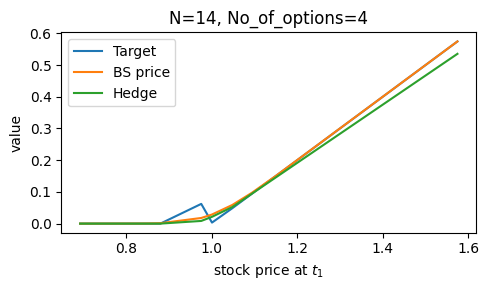

In [ ]:
#PLOT AND CHECK HOW IT LOOKS

Weights_opt_with_ridge = result_data_with_ridge["w_opt"]
P_matrix_with_ridge = result_data_with_ridge["p_matrix"]

plot_one_run( K1,
    K2,
    truncation_range,
    N,
    Weights_opt_with_ridge,
    P_matrix_with_ridge,
    marg,
    K,
    T_GRID,
    sigma,
    r,
    short_strikes,
    run_idx=None,
    save=True,
    folder='BS_Asian_plots_MAY_2025',
    fname='Conditional_plot_with_ridge_zoomed_in',        
    show=True,
    asian_payoff=Asian_option_payoff,
    bs_call=BS_call,
    lo = 2,
    hi = -2
)

In [ ]:
run_dict_with_ridge['Hedge_value']

np.float64(0.05842817739069744)

**EXPERIMENT 4: Run the minimization algorithm with lasso regularization term**

In [ ]:
if __name__ == "__main__":
    regularization = "ridge"
    
    list_of_objectives = []
    list_of_dictionaries = []
    
    lmda_reg = 0.005
    
    result_data_with_lasso = run_experiment_no_M(solver="gurobi",
        truncation_range=truncation_range,
        N=N,
        no_of_options=no_of_options,
        short_strikes=short_strikes,
        epsilon= 0,
        M_bound= 0,
        choice="non-uniform",
        x0 = [0] *(no_of_options+1 ),
        regularization = "lasso",
        lmda_reg = lmda_reg                                       
    )



    # Make a similar dictionary
    run_dict_with_lasso = {
        "Solver": "gurobi",
        "M_coeff": "No_M",   # or 0, or None—some label
        "Truncation_range": truncation_range,
        "N_initial": result_data_with_lasso["N_initial"],
        "N": result_data_with_lasso["N"],
        "no_of_options": no_of_options,
        "epsilon": 0.0,
        "regularization_parameter": lmda_reg,
        "Optimal_weights": result_data_with_lasso["w_opt"],
         "Final_value": result_data_with_lasso["final_value"],
         "P_matrix": result_data_with_lasso["p_matrix"],
        "Target_price": result_data_with_lasso["target_call_price"],
        "Hedge_value": result_data_with_lasso["hedge_value"]
     }
    print(f"========== Experiment Complete ==========")

    print("Optimal Weights:", result_data_with_lasso["w_opt"])
    print("Final Value from min-max:", result_data_with_lasso["final_value"])
        
        


The interpolated line takes the value 0 at 2.0081747254138964
Strike:2.0081747254138964,Interpolated call value:-1.6601845766184287e-19
The new discretization points are:[[0.         0.65985287 0.69305573 0.83860362 0.86371482 0.88043542
  0.97595447 1.00102542 1.0484879  1.0944914  1.09459717 1.15062857
  1.57436388 2.         2.00817473]
 [0.         0.65985287 0.69305573 0.83860362 0.86371482 0.88043542
  0.97595447 1.00102542 1.0484879  1.0944914  1.09459717 1.15062857
  1.57436388 2.         2.00817473]]
Number of discretization points are:15
timepoint: 0.5
15
Sum of marginals at 0.5 is: 1.0
timepoint: 1
15
Sum of marginals at 1 is: 1.0
Short strikes: [1.001, 0.976, 1.0485, 0.8804]
Short call value 0 is: 0.055902473578919115
Short call value 1 is: 0.06851541075851549
Short call value 2 is: 0.03669138068430052
Short call value 3 is: 0.1328897732519189
length of short_call 4
value from gurobi:0.06796843220585114
val solving max LP:0.06796843220585112

value from gurobi:0.06789014866

value from gurobi:0.050827240350659456
val solving max LP:0.053777097338261956

value from gurobi:0.049300035871381286
val solving max LP:0.05226045226042101

value from gurobi:0.047468944490903976
val solving max LP:0.050640551434999494

value from gurobi:0.048927955208676294
val solving max LP:0.05162912777577075

value from gurobi:0.04730138967474192
val solving max LP:0.050135843422417316

value from gurobi:0.04544837175550182
val solving max LP:0.048324546034343656

value from gurobi:0.044852816670367404
val solving max LP:0.04798074032366767

value from gurobi:0.04152528748668517
val solving max LP:0.04492859707690189

value from gurobi:0.04313505853632934
val solving max LP:0.04607165802254016

value from gurobi:0.040413416807534144
val solving max LP:0.04388508414983308

value from gurobi:0.03624104146943906
val solving max LP:0.040166603580745044

value from gurobi:0.036548988604248524
val solving max LP:0.04037311700142244

value from gurobi:0.03619548707912394
val solving ma

value from gurobi:0.031071749149631636
val solving max LP:0.03589119025675662

value from gurobi:0.03107224405905871
val solving max LP:0.03587250038773604

value from gurobi:0.031047459460391853
val solving max LP:0.035862306144029146

value from gurobi:0.031022024336605176
val solving max LP:0.03582197486733662

value from gurobi:0.03101364047455834
val solving max LP:0.035830921508196154

value from gurobi:0.03097797566848038
val solving max LP:0.035793241034952225

value from gurobi:0.030916318649990292
val solving max LP:0.03572526665770559

value from gurobi:0.030994303020661182
val solving max LP:0.035763760119847485

value from gurobi:0.030961504778465397
val solving max LP:0.035724653045849625

value from gurobi:0.030956850909426965
val solving max LP:0.03568395907021082

value from gurobi:0.030867171313525198
val solving max LP:0.035636008029486306

value from gurobi:0.030768920861855443
val solving max LP:0.0355220436984115

value from gurobi:0.030825254641531786
val solving

value from gurobi:0.01937526142191159
val solving max LP:0.025212421871391784

value from gurobi:0.020339443663230747
val solving max LP:0.02598721995399053

value from gurobi:0.019399085738540642
val solving max LP:0.0251444746018633

value from gurobi:0.022084585569936015
val solving max LP:0.0276581059674157

value from gurobi:0.019196492318648294
val solving max LP:0.024947745334996295

value from gurobi:0.020521275271557067
val solving max LP:0.02614658781137082

value from gurobi:0.02050528569046378
val solving max LP:0.026167997841039382

value from gurobi:0.019453749212010988
val solving max LP:0.025405356091745934

value from gurobi:0.01929528194958744
val solving max LP:0.025035631373786546

value from gurobi:0.019397721922799614
val solving max LP:0.02513141787227338

value from gurobi:0.021499959699305925
val solving max LP:0.02706798912910889

value from gurobi:0.01924277971937748
val solving max LP:0.025120722985094823

value from gurobi:0.019747001763951805
val solving m

value from gurobi:0.016544979954714937
val solving max LP:0.022550581998357595

value from gurobi:0.016570232684269753
val solving max LP:0.02259787062339674

value from gurobi:0.01655357312797744
val solving max LP:0.022577676218947018

value from gurobi:0.01664679866758186
val solving max LP:0.02265552847975533

value from gurobi:0.016468972265326325
val solving max LP:0.022491399121982156

value from gurobi:0.01657702352428861
val solving max LP:0.02259097717356559

value from gurobi:0.01649531196274357
val solving max LP:0.02251609023135056

value from gurobi:0.016591682843518852
val solving max LP:0.022628262764227927

value from gurobi:0.016481889383228046
val solving max LP:0.022495051120069796

value from gurobi:0.016501124228838697
val solving max LP:0.022518990100069476

value from gurobi:0.016491689099658223
val solving max LP:0.02250445766742175

value from gurobi:0.016508027760090187
val solving max LP:0.022525776731102114

value from gurobi:0.016460148629246545
val solvin

value from gurobi:0.016423793545027474
val solving max LP:0.0224431238549197

value from gurobi:0.016423080905975006
val solving max LP:0.022443266812253226

value from gurobi:0.0164233556800043
val solving max LP:0.02244304611688471

value from gurobi:0.016422840822655056
val solving max LP:0.022443093210354446

value from gurobi:0.016423477525951097
val solving max LP:0.022443335244511992

value from gurobi:0.0164227950524889
val solving max LP:0.022443004521265335

value from gurobi:0.016423017894970283
val solving max LP:0.022443223114768374

value from gurobi:0.016422856828361157
val solving max LP:0.02244304171150062

value from gurobi:0.016422965329139463
val solving max LP:0.02244316083830576

value from gurobi:0.016423286069459277
val solving max LP:0.022443490485444903

value from gurobi:0.01642281215204125
val solving max LP:0.022443014811557825

value from gurobi:0.016423361367976216
val solving max LP:0.022443014909232322

value from gurobi:0.016423288337786373
val solving

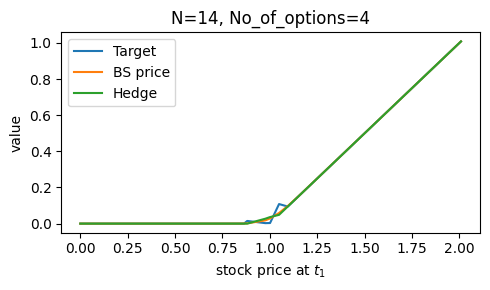

In [ ]:
#PLOT AND CHECK HOW IT LOOKS

Weights_opt_with_lasso = result_data_with_lasso["w_opt"]
P_matrix_with_lasso = result_data_with_lasso["p_matrix"]

plot_one_run( K1,
    K2,
    truncation_range,
    N,
    Weights_opt_with_lasso,
    P_matrix_with_lasso,
    marg,
    K,
    T_GRID,
    sigma,
    r,
    short_strikes,
    run_idx=None,
    save=False,
    folder='BS_Asian_plots_MAY_2025',
    fname='Conditional_plot_with_lasso',        
    show=True,
    asian_payoff=Asian_option_payoff,
    bs_call=BS_call,
#     lo = 2,
#     hi = -2         
)

In [ ]:
run_dict_with_lasso['Hedge_value']

np.float64(0.06450825239613175)

In [ ]:
#store the objective value for each stock path simulation till short maturity i.e. time_indices[index1]
objective_value_list_intermediate_time_no_bounds = np.zeros((index1+1,Nsim))

for i in range(index1+1):
        for j in range(len(stock_paths[:,i])):
             #objective value at the intermediate time points
            objective_value_list_intermediate_time_no_bounds[i,j] = objective_value_for_stock_paths(time_indices[i],
                                                         stock_paths[j,i],
                                                         Weights_opt_without_bounds,
                                                         T_GRID,K,
                                                         short_strikes)
        

In [ ]:
#store the objective value for each stock path simulation till short maturity i.e. time_indices[index1]
objective_value_list_intermediate_time_with_bounds = np.zeros((index1+1,Nsim))

for i in range(index1+1):
        for j in range(len(stock_paths[:,i])):
             #objective value at the intermediate time points
            objective_value_list_intermediate_time_with_bounds[i,j] = objective_value_for_stock_paths(time_indices[i],
                                                         stock_paths[j,i],
                                                         Weights_opt_with_bounds,
                                                         T_GRID,K,
                                                         short_strikes)

In [ ]:
#store the objective value for each stock path simulation till short maturity i.e. time_indices[index1]
objective_value_list_intermediate_time_with_ridge = np.zeros((index1+1,Nsim))

for i in range(index1+1):
        for j in range(len(stock_paths[:,i])):
             #objective value at the intermediate time points
            objective_value_list_intermediate_time_with_ridge[i,j] = objective_value_for_stock_paths(time_indices[i],
                                                         stock_paths[j,i],
                                                         Weights_opt_with_ridge,
                                                         T_GRID,K,
                                                         short_strikes)

In [ ]:
#store the objective value for each stock path simulation till short maturity i.e. time_indices[index1]
objective_value_list_intermediate_time_with_lasso = np.zeros((index1+1,Nsim))

for i in range(index1+1):
        for j in range(len(stock_paths[:,i])):
             #objective value at the intermediate time points
            objective_value_list_intermediate_time_with_lasso[i,j] = objective_value_for_stock_paths(time_indices[i],
                                                         stock_paths[j,i],
                                                         Weights_opt_with_lasso,
                                                         T_GRID,K,
                                                         short_strikes)

In [ ]:
#list to store the objective values

objective_value_full_list_for_diff_methods = [objective_value_list_intermediate_time_no_bounds,
                                         objective_value_list_intermediate_time_with_bounds,
                                         objective_value_list_intermediate_time_with_ridge,
                                         objective_value_list_intermediate_time_with_lasso]


#list to store the min-max values for the four methods
min_max_list_for_different_methods = [result_data_no_bounds["final_value"],
                                      result_data_with_bounds["final_value"],
                                      result_data_with_lasso["final_value"],
                                      result_data_with_ridge["final_value"]]

#list to store the weights
optimal_weights_list = [Weights_opt_without_bounds,
                        Weights_opt_with_bounds,
                        Weights_opt_with_ridge,
                        Weights_opt_with_lasso]


#list to store the methods used
methods_list = ["no bounds","with bounds", "ridge", "lasso"]

In [ ]:
#Compute the maximum/peak PFEs with respect to each weight combination till short maturity

peak_PFE_99_list = []
peak_PFE_95_list = []
peak_PFE_5_list = []
peak_PFE_1_list = []
mean_absolute_error_list = []

    
for i,element in enumerate(objective_value_full_list_for_diff_methods):#get the index and the corresponding element from the list
    
    print(f"The optimal weights for {i+1} options are:{optimal_weights_list[i]}")
    
    #print the shape of the the ith element: should be index1 x Nsim
    print(f"Shape of the {i}th element:{element.shape}")
    
    #compute the PFEs at each time point till short maturity
    ninety_nine_percentile_list = np.percentile(element,99, axis=1)
    ninety_fifth_percentile_list = np.percentile(element,95,axis=1) 
    fifth_percentile_list = np.percentile(element,5,axis=1)
    first_percentile_list = np.percentile(element,1,axis=1) 
    mean_of_absolute_error = np.mean(np.abs(element),axis=1) 
    
    #compute the peak PFEs
    peak_PFE_99 = np.max(ninety_nine_percentile_list)
    peak_PFE_95 = np.max(ninety_fifth_percentile_list)
    peak_PFE_5 = np.min(fifth_percentile_list)
    peak_PFE_1 = np.min(first_percentile_list)
    peak_mean_absolute_error = mean_of_absolute_error[-1] 
    
#     print(f"Peak mean absolute error is: {peak_mean_absolute_error}")
#     print(mean_of_absolute_error[-1])
   
    peak_PFE_99_list.append(peak_PFE_99)
    peak_PFE_95_list.append(peak_PFE_95)
    peak_PFE_5_list.append(peak_PFE_5)
    peak_PFE_1_list.append(peak_PFE_1)
    mean_absolute_error_list.append(mean_of_absolute_error[-1])
    
    

The optimal weights for 1 options are:[ 5.01323326e-07  9.99458923e-01  4.75215230e-03 -8.32513116e-03
  4.55337175e-03]
Shape of the 0th element:(11, 10000)
The optimal weights for 2 options are:[-1.68711833e-05 -5.00000000e-01  4.95178515e-01  5.00000000e-01
  3.26126023e-01]
Shape of the 1th element:(11, 10000)
The optimal weights for 3 options are:[4.34806229e-07 1.31826943e-01 4.31062283e-01 2.67384278e-01
 8.81420924e-02]
Shape of the 2th element:(11, 10000)
The optimal weights for 4 options are:[-2.56488761e-10 -1.02017436e-01  7.77430668e-02  7.40457950e-01
  2.83816099e-01]
Shape of the 3th element:(11, 10000)


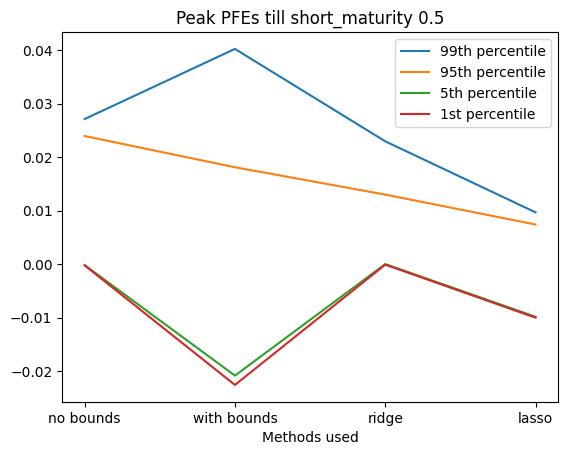

In [ ]:
plt.plot(methods_list,peak_PFE_99_list,label='99 level VAR')
plt.plot(methods_list,peak_PFE_95_list,label='95 level VAR')
plt.plot(methods_list,peak_PFE_5_list,label='5 level VAR')
plt.plot(methods_list,peak_PFE_1_list,label='1 level VAR')
plt.xticks(methods_list)
plt.xlabel("Methods used")
plt.title(f"Peak PFEs till short_maturity {T_GRID[1]}")
plt.legend()
plt.show()
plt.close()

/tmp/ipykernel_1589123/2811752863.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(methods_list, rotation=15, ha="right")
/tmp/ipykernel_1589123/2811752863.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(methods_list, rotation=15, ha="right")


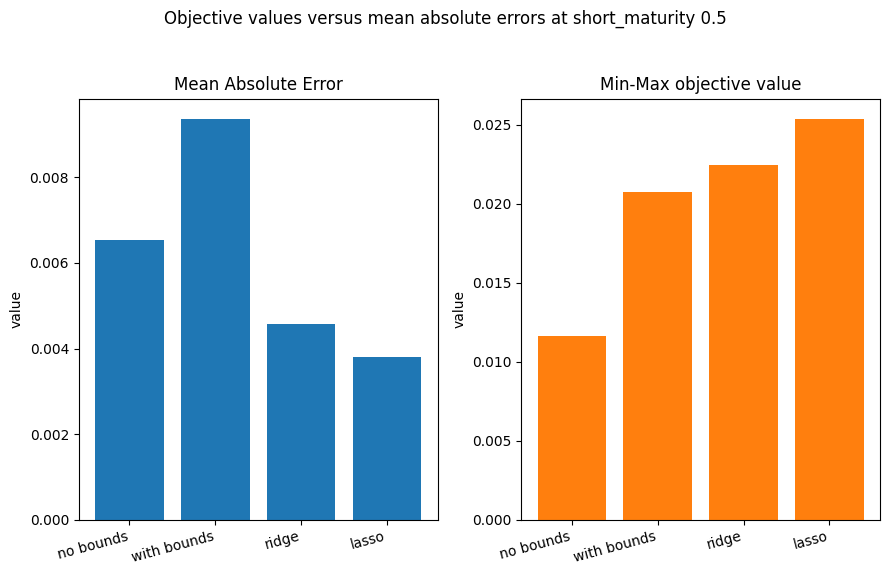

In [ ]:
#Plot the mean absolute errors and the objective values of the minmax for the four methods
import matplotlib.pyplot as plt

# --------------------------------------------------------------------
# data  (already in your workspace)
# methods_list              = ['no bounds', 'with bounds', 'ridge', 'lasso']
# peak_PFE_99_list          = [...]
# peak_PFE_95_list          = [...]
# peak_PFE_5_list           = [...]
# peak_PFE_1_list           = [...]
# --------------------------------------------------------------------

# map each list to a nicer name to loop easily
series = [
    ("Mean Absolute Error", mean_absolute_error_list, "tab:blue"),
    ("Min-Max objective value",min_max_list_for_different_methods , "tab:orange"),
]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 6), sharex=True)
axes = axes.ravel()                       # flatten 2×2 → 1-D iterator

for ax, (title, values, colour) in zip(axes, series):
    ax.bar(methods_list, values, color=colour)
    ax.set_title(title)
    ax.set_ylabel("value")
    ax.set_xticklabels(methods_list, rotation=15, ha="right")

fig.suptitle(f"Objective values versus mean absolute errors at short_maturity {T_GRID[1]}")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])   # leave room for suptitle
plt.savefig(f"{folder}/min-max vs MAE till short_maturity {T_GRID[1]}.png", dpi=300, bbox_inches="tight")

# ------------- append a tiny CSV log -----------------------------
logfile = Path(folder) / "plot_index.csv"
plt.show()


/tmp/ipykernel_1589123/4218444132.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(methods_list, rotation=15, ha="right")
/tmp/ipykernel_1589123/4218444132.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(methods_list, rotation=15, ha="right")
/tmp/ipykernel_1589123/4218444132.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(methods_list, rotation=15, ha="right")
/tmp/ipykernel_1589123/4218444132.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(methods_list, rotation=15, ha="right")


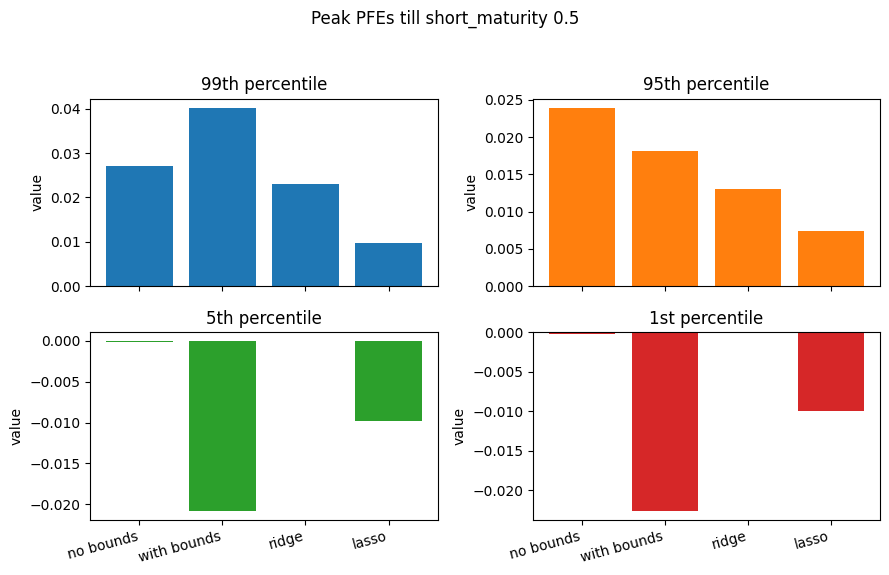

In [ ]:
#PLOT THE PFEs of the four methods

import matplotlib.pyplot as plt

# --------------------------------------------------------------------
# data  (already in your workspace)
# methods_list              = ['no bounds', 'with bounds', 'ridge', 'lasso']
# peak_PFE_99_list          = [...]
# peak_PFE_95_list          = [...]
# peak_PFE_5_list           = [...]
# peak_PFE_1_list           = [...]
# --------------------------------------------------------------------

# map each list to a nicer name to loop easily
series = [
    ("99th percentile", peak_PFE_99_list, "tab:blue"),
    ("95th percentile", peak_PFE_95_list, "tab:orange"),
    ("5th percentile",  peak_PFE_5_list,  "tab:green"),
    ("1st percentile",  peak_PFE_1_list,  "tab:red"),
]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 6), sharex=True)
axes = axes.ravel()                       # flatten 2×2 → 1-D iterator

for ax, (title, values, colour) in zip(axes, series):
    ax.bar(methods_list, values, color=colour)
    ax.set_title(title)
    ax.set_ylabel("value")
    ax.set_xticklabels(methods_list, rotation=15, ha="right")

fig.suptitle(f"Peak PFEs till short_maturity {T_GRID[1]}")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])   # leave room for suptitle
plt.savefig(f"{folder}/Peak PFEs till short_maturity {T_GRID[1]}.png", dpi=300, bbox_inches="tight")

# ------------- append a tiny CSV log -----------------------------
logfile = Path(folder) / "plot_index.csv"
plt.show()


/tmp/ipykernel_1589123/125368569.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(methods_list, rotation=15, ha="right")
/tmp/ipykernel_1589123/125368569.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(methods_list, rotation=15, ha="right")


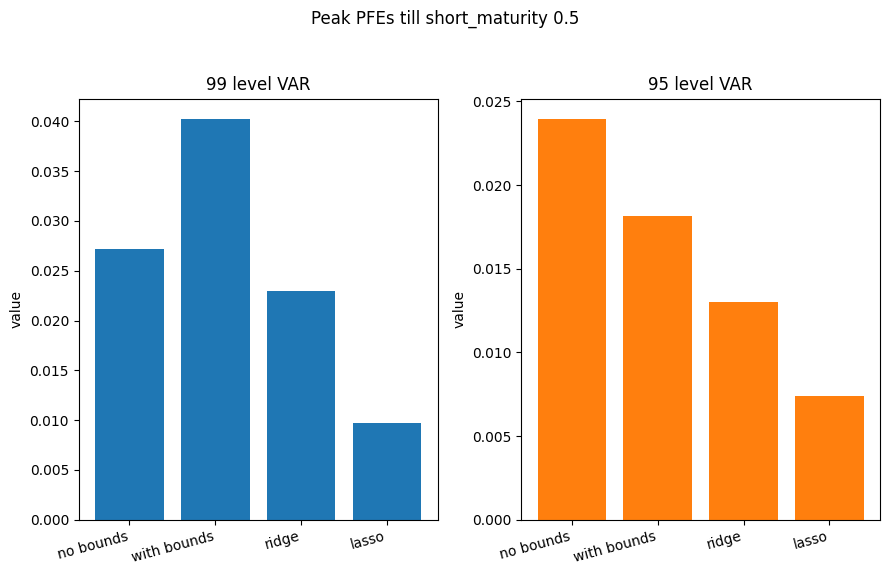

In [ ]:
#PLOT THE PFEs of the four methods

import matplotlib.pyplot as plt
from datetime import datetime

# --------------------------------------------------------------------
# data  (already in your workspace)
# methods_list              = ['no bounds', 'with bounds', 'ridge', 'lasso']
# peak_PFE_99_list          = [...]
# peak_PFE_95_list          = [...]
# peak_PFE_5_list           = [...]
# peak_PFE_1_list           = [...]
# --------------------------------------------------------------------

# map each list to a nicer name to loop easily
series = [
    ("99 level VAR", peak_PFE_99_list, "tab:blue"),
    ("95 level VAR", peak_PFE_95_list, "tab:orange"),
]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 6), sharex=True)
axes = axes.ravel()                       # flatten 2×2 → 1-D iterator

for ax, (title, values, colour) in zip(axes, series):
    ax.bar(methods_list, values, color=colour)
    ax.set_title(title)
    ax.set_ylabel("value")
    ax.set_xticklabels(methods_list, rotation=15, ha="right")

#Add a time_stamp to prevent accidental overwriting    
 # timestamp: YYYY-MM-DD_HHMMSS
ts  = datetime.now().strftime("%Y-%m-%d_%H%M%S")
    
fig.suptitle(f"Peak PFEs till short_maturity {T_GRID[1]}")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])   # leave room for suptitle
plt.savefig(f"{folder}/{ts} VAR till short_maturity {T_GRID[1]}.png", dpi=300, bbox_inches="tight")

# ------------- append a tiny CSV log -----------------------------
logfile = Path(folder) / "plot_index.csv"
plt.show()


In [ ]:
!zip -r BS_Asian_plots_MAY_2025.zip BS_Asian_plots_MAY_2025

updating: BS_Asian_plots_MAY_2025/ (stored 0%)
updating: BS_Asian_plots_MAY_2025/plot_index.csv (deflated 77%)
updating: BS_Asian_plots_MAY_2025/2025-05-01_125345_Conditional_plot_with_ridge.png (deflated 10%)
updating: BS_Asian_plots_MAY_2025/.ipynb_checkpoints/ (stored 0%)
updating: BS_Asian_plots_MAY_2025/2025-05-01_124523_Conditional_plot_no_bounds.png (deflated 12%)
updating: BS_Asian_plots_MAY_2025/2025-05-01_125144_Conditional_plot_with_bounds_zoomed_in.png (deflated 9%)
updating: BS_Asian_plots_MAY_2025/2025-05-01_125420_Conditional_plot_with_ridge_zoomed_in.png (deflated 9%)
updating: BS_Asian_plots_MAY_2025/2025-05-01_125220_Conditional_plot_with_bounds.png (deflated 10%)
updating: BS_Asian_plots_MAY_2025/Peak PFEs till short_maturity 0.5.png (deflated 25%)
updating: BS_Asian_plots_MAY_2025/2025-05-01_124808_Conditional_plot_no_bounds_zoomed_in.png (deflated 11%)
updating: BS_Asian_plots_MAY_2025/min-max vs MAE till short_maturity 0.5.png (deflated 25%)
updating: BS_Asian_plo